# ETL Spark Streaming Development Process


## Key Topics

* Core Concepts
* Architecture
* Spark in Production
* The Need for Streaming ETL
* Transforming Raw Logs with Structured Streaming
* Data Exploration using PySpark



# Core Concepts

Before diving deep into how Apache Spark works, lets understand the jargon of Apache Spark

1) Job: A piece of code which reads some input from HDFS or local, performs some 
computation on the data and writes some output data.
<br><br>
2) Stages: Jobs are divided into stages. Stages are classified as a Map or reduce stages (Its easier to understand if you have worked on Hadoop and want to correlate). Stages are divided based on computational boundaries, all computations (operators) cannot be Updated in a single Stage. It happens over many stages.
<br><br>
3) Tasks: Each stage has some tasks, one task per partition. One task is executed on one partition of data on one executor (machine).
<br><br>
4) DAG: DAG stands for Directed Acyclic Graph, in the present context its a DAG of operators.
<br><br>
5) Executor: The process responsible for executing a task.
<br><br>
6) Master: The machine on which the Driver program runs
<br><br>
7) Slave: The machine on which the Executor program runs

##Spark Components

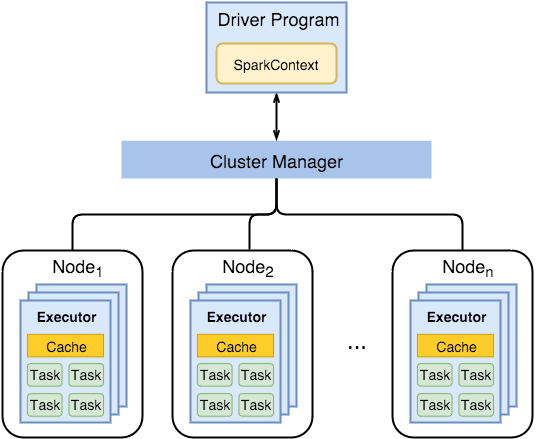

1) Spark Driver

    a) separate process to execute user applications

    b) creates SparkContext to schedule jobs execution and negotiate with cluster manager

2) Executors

     a) run tasks scheduled by driver

     b) store computation results in memory, on disk or off-heap

     c) interact with storage systems

3) Cluster Manager

    a) Mesos

    b) YARN

    c) Spark Standalone


  Spark Driver contains more components responsible for translation of user code into actual jobs executed on cluster:

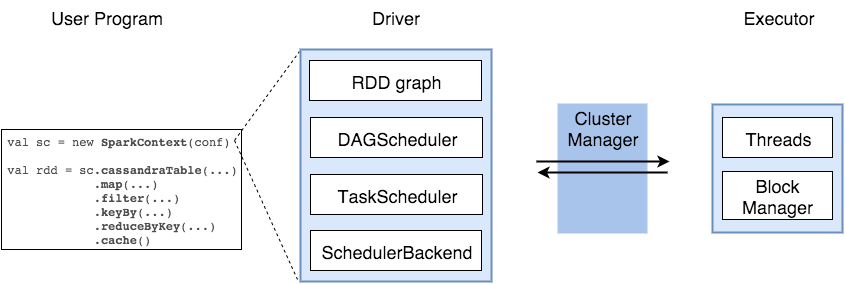

* SparkContext
    * represents the connection to a Spark cluster, and can be used to create RDDs, accumulators and broadcast variables on that cluster
<br><br>

* DAGScheduler
  * computes a DAG of stages for each job and submits them to TaskScheduler determines preferred locations for tasks (based on cache status or shuffle files locations) and finds minimum schedule to run the jobs
<br><br>

* TaskScheduler
  * responsible for sending tasks to the cluster, running them, retrying if there are failures, and mitigating stragglers

<br><br>

* SchedulerBackend
  * backend interface for scheduling systems that allows plugging in different implementations(Mesos, YARN, Standalone, local)
<br><br>


* BlockManager
  * provides interfaces for putting and retrieving blocks both locally and remotely into various stores (memory, disk, and off-heap)

# Architecture 
## How Spark Works?

Spark has a small code base and the system is divided in various layers. Each layer has some responsibilities. The layers are independent of each other.

The first layer is the interpreter, Spark uses a Scala interpreter, with some modifications. As you enter your code in spark console (creating RDD’s and applying operators), Spark creates a operator graph. When the user runs an action (like collect), the Graph is submitted to a DAG Scheduler. The DAG scheduler divides operator graph into (map and reduce) stages. A stage is comprised of tasks based on partitions of the input data. The DAG scheduler pipelines operators together to optimize the graph. For e.g. Many map operators can be scheduled in a single stage. This optimization is key to Sparks performance. The final result of a DAG scheduler is a set of stages. The stages are passed on to the Task Scheduler. The task scheduler launches tasks via cluster manager. (Spark Standalone/Yarn/Mesos). The task scheduler doesn’t know about dependencies among stages.



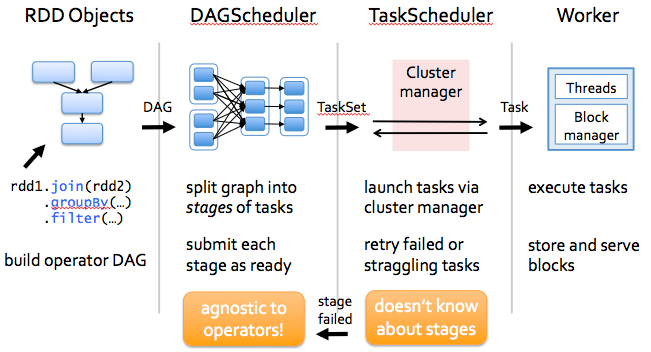

# Spark in Production

We are well into the Big Data era, with organizations collecting massive amounts of data on a continual basis. Yet, the value of this data deluge hinges on the ability to extract actionable insights in a timely fashion. Hence, there is an increasing need for continuous applications that can derive real-time actionable insights from massive data ingestion pipelines.
<br>
<br>
However, building production-grade continuous applications can be challenging, as developers need to overcome many obstacles, including: <br>


*   **Providing end-to-end reliability and correctness guarantees**: Long running data processing systems must be resilient to failures by ensuring that outputs are consistent with results processed in batch. Additionally, unusual activities (e.g failures in upstream components, traffic spikes, etc.) must be continuously monitored and automatically mitigated to ensure highly available insights are delivered in real-time.
*   **Performing complex transformations**: Data arrives in a myriad formats (CSV, JSON, Avro, etc.) that often must be restructured, transformed and augmented before being consumed. Such restructuring requires that all the traditional tools from batch processing systems are available, but without the added latencies that they typically entail.
*   **Handling late or out-of-order data**: When dealing with the physical world, data arriving late or out-of-order is a fact of life. As a result, aggregations and other complex computations must be continuously (and accurately) revised as new information arrives.
*   **Integrating with other systems**:  Information originates from a variety of sources (Kafka, HDFS, S3, etc), which must be integrated to see the complete picture.

<br>
<br>

**Structured Streaming in Apache Spark builds upon the strong foundation of Spark SQL, leveraging its powerful APIs to provide a seamless query interface, while simultaneously optimizing its execution engine to enable low-latency, continually updated answers.** This blog post kicks off a series in which we will explore how we are using the new features of Apache Spark 2.1 to overcome the above challenges and build our own production pipelines.
<br><br>


In this section, we will focus on an ETL pipeline that converts raw AWS CloudTrail audit logs into a JIT data warehouse for faster ad-hoc queries. We will show how easy it is to take an existing batch ETL job and subsequently productize it as a real-time streaming pipeline using Structured Streaming in Databricks. Using this pipeline, we have converted 3.8 million JSON files containing 7.9 billion records into a Parquet table, which allows us to do ad-hoc queries on updated-to-the-minute Parquet table 10x faster than those on raw JSON files.

###The Need for Streaming ETL
**ETL V/S RDBMS**
<br>
Operations and queries which run sub-second on a single RDBMS server can, and may, take minutes to run on small Spark cluster. At times this can be quite disconcerting to those who anticipate that big data technologies offer highly performant, distributed processing environments in all situations.
<br><br>
A google search will reveal the many differences of big data technologies like Spark vs RDBMS, but to my mind many of them can be distilled down to a few key differences in the context of ETL. Big data technologies like Spark:
          
          1) will favour an immutable (append-only) data source
          2) joins (the shuffle) and updates are “expensive” operations
          3) records are stored in files (based on partition configuration and usually in columnar format) and operations such as updates to one row require re-writing the entire file
          4) No sequence generator — dataframes are distributed in-memory data structures so the idea of monotonically increasing IDs in streaming mode is not possible. In batch mode, one can use the monotonically_increasing_id function but has limitations
          5) highly normalised data is a big data anti-pattern (because it requires many joins) but fortunately this doesn’t apply to dimensional modelling and in fact with the modern data warehouse you may choose to denormalise the dimensional model further for performance reasons
          6) Filter, transform, and clean up data – Raw data is naturally messy and needs to be cleaned up to fit into a well-defined structured format. For example, parsing timestamp strings to date/time types for faster comparisons, filtering corrupted data, nesting/unnesting/flattening complex structures to better organize important columns, etc.]
          7) Convert to a more efficient storage format – Text, JSON and CSV data are easy to generate and are human readable, but are very expensive to query. Converting it to more efficient formats like Parquet, Avro, or ORC can reduce file size and improve processing speed.
          8) Partition data by important columns – By partitioning the data based on the value of one or more columns, common queries can be answered more efficiently by reading only the relevant fraction of the total dataset.

It’s not to say joins and updates shouldn’t be performed. With Delta Lake, both can be optimised more than ever before, but there is still no such index structure to help you locate specific records. Joins have to often shuffle large amounts of data across the cluster to locate matching keys. Updates require an entire file to be read and rewritten just to update one record. Therefore in most situations, I would recommend running updates or merges during batch operations (although I do provide an example of running a merge operation in a streaming pipeline). The business may need to think carefully about what really needs to be low latency/real-time vs processed at regular intervals. Alternatively you may consider Cosmos DB for workloads that run multiple isolated updates, but require low latency guarantees.

<br>
With all of these differences, you may be wondering why you should consider Spark for ETL workloads? As data volumes increase rapidly, customer are finding it increasingly more expensive to store all their data in an RDBMS. Many are turning to data lakes to reduce TCO, and one of the best way to process and run analytics on top of a data lake is using Spark.

Traditionally, ETL is performed as periodic batch jobs. For example, dump the raw data in real time, and then convert it to structured form every few hours to enable efficient queries. We had initially setup our system this way, but this technique incurred a high latency; we had to wait for few hours before getting any insights. For many use cases, this delay is unacceptable. When something suspicious is happening in an account, we need to be able to ask questions immediately. Waiting minutes to hours could result in an unreasonable delay in responding to an incident.
<br><br>
Fortunately, Structured Streaming makes it easy to convert these periodic batch jobs to a real-time data pipeline. Streaming jobs are expressed using the same APIs as batch data. Additionally, the engine provides the same fault-tolerance and data consistency guarantees as periodic batch jobs, while providing much lower end-to-end latency.
<br><br>
In the rest of notebook, we dive into the details of how we transform AWS CloudTrail audit logs into an efficient, partitioned, parquet data warehouse. AWS CloudTrail allows us to track all actions performed in a variety of AWS accounts, by delivering gzipped JSON logs files to a S3 bucket. These files enable a variety of business and mission critical intelligence, such as cost attribution and security monitoring. However, in their original form, they are very costly to query, even with the capabilities of Apache Spark. To enable rapid insight, we run a Continuous Application that transforms the raw JSON logs files into an optimized Parquet table. Let’s dive in and look at how to write this pipeline. 


### Transforming Raw Logs with Structured Streaming

We start by defining the schema of the JSON records based on CloudTrail documentation.

In [ ]:
cloudTrailLogsPath = "s3n://MY_CLOUDTRAIL_BUCKET/AWSLogs/*/CloudTrail/*/2017/01/03/"
parquetOutputPath = "/MY_OUTPUT_PATH"  # DBFS or S3 path 

In [ ]:
from pyspark.sql.functions import *
from pyspark.sql.streaming import ProcessingTime
from pyspark.sql.types import *
from datetime import datetime

cloudTrailSchema = StructType() \
  .add("Records", ArrayType(StructType() \
    .add("additionalEventData", StringType()) \
    .add("apiVersion", StringType()) \
    .add("awsRegion", StringType()) \
    .add("errorCode", StringType()) \
    .add("errorMessage", StringType()) \
    .add("eventID", StringType()) \
    .add("eventName", StringType()) \
    .add("eventSource", StringType()) \
    .add("eventTime", StringType()) \
    .add("eventType", StringType()) \
    .add("eventVersion", StringType()) \
    .add("readOnly", BooleanType()) \
    .add("recipientAccountId", StringType()) \
    .add("requestID", StringType()) \
    .add("requestParameters", MapType(StringType(), StringType())) \
    .add("resources", ArrayType(StructType() \
      .add("ARN", StringType()) \
      .add("accountId", StringType()) \
      .add("type", StringType()) \
    )) \
    .add("responseElements", MapType(StringType(), StringType())) \
    .add("sharedEventID", StringType()) \
    .add("sourceIPAddress", StringType()) \
    .add("serviceEventDetails", MapType(StringType(), StringType())) \
    .add("userAgent", StringType()) \
    .add("userIdentity", StructType() \
      .add("accessKeyId", StringType()) \
      .add("accountId", StringType()) \
      .add("arn", StringType()) \
      .add("invokedBy", StringType()) \
      .add("principalId", StringType()) \
      .add("sessionContext", StructType() \
        .add("attributes", StructType() \
          .add("creationDate", StringType()) \
          .add("mfaAuthenticated", StringType()) \
        ) \
        .add("sessionIssuer", StructType() \
          .add("accountId", StringType()) \
          .add("arn", StringType()) \
          .add("principalId", StringType()) \
          .add("type", StringType()) \
          .add("userName", StringType()) \
        )
      ) \
      .add("type", StringType()) \
      .add("userName", StringType()) \
      .add("webIdFederationData", StructType() \
        .add("federatedProvider", StringType()) \
        .add("attributes", MapType(StringType(), StringType())) \
      )
    ) \
    .add("vpcEndpointId", StringType())))


With this, we can define a streaming DataFrame that represents the data stream from CloudTrail files that are being written in a S3 bucket.

In [ ]:
rawRecords = spark.readStream \
  .option("maxFilesPerTrigger", "100") \
  .schema(cloudTrailSchema) \
  .json(cloudTrailLogsPath)

A good way to understand what this rawRecords DataFrame represents is to first understand the Structured Streaming programming model. The key idea is to treat any data stream as an unbounded table: new records added to the stream are like rows being appended to the table.

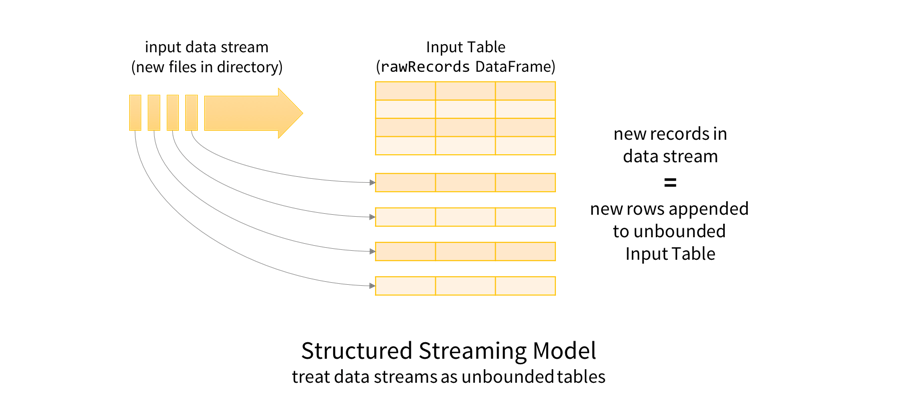

This allows us to treat both batch and streaming data as tables. Since tables and DataFrames/Datasets are semantically synonymous, the same batch-like DataFrame/Dataset queries can be applied to both batch and streaming data. In this case, we will transform the raw JSON data such that it’s easier to query using Spark SQL’s built-in support for manipulating complex nested schemas. Here is an abridged version of the transformation.

In [ ]:
cloudTrailEvents = rawRecords \
  .select(explode("Records").alias("record")) \
  .select(
    unix_timestamp("record.eventTime", "yyyy-MM-dd'T'hh:mm:ss").cast("timestamp").alias("timestamp"),
    "record.*")

Here, we explode (split) the array of records loaded from each file into separate records. We also parse the string event time string in each record to Spark’s timestamp type, and flatten out the nested columns for easier querying. Note that if cloudtrailEvents was a batch DataFrame on a fixed set of files, then we would have written the same query, and we would have written the results only once as parsed.write.parquet("/cloudtrail"). Instead, we will start a StreamingQuery that runs continuously to transform new data as it arrives.

In [ ]:
checkpointPath = "/cloudtrail.checkpoint/

streamingETLQuery = cloudTrailEvents \
  .withColumn("date", cloudTrailEvents.timestamp.cast("date")) \
  .writeStream \
  .format("parquet") \
  .option("path", parquetOutputPath) \
  .partitionBy("date") \
  .trigger(processingTime="10 seconds") \
  .option("checkpointLocation", checkpointPath) \
  .start()

Here we are specifying the following configurations for the StreamingQuery before starting it.

     1) Derive the date from the timestamp column
     2) Check for new files every 10 seconds (i.e., trigger interval)
     3) Write the transformed data from parsed DataFrame as a Parquet-formatted table at the path /cloudtrail
     4) Partition the Parquet table by date so that we can later efficiently query time slices of the data; a key requirement in monitoring applications.
     5) Save checkpoint information at the path /checkpoints/cloudtrail for fault-tolerance (explained later in the blog)

In terms of the Structured Streaming Model, this is how the execution of this query is performed.

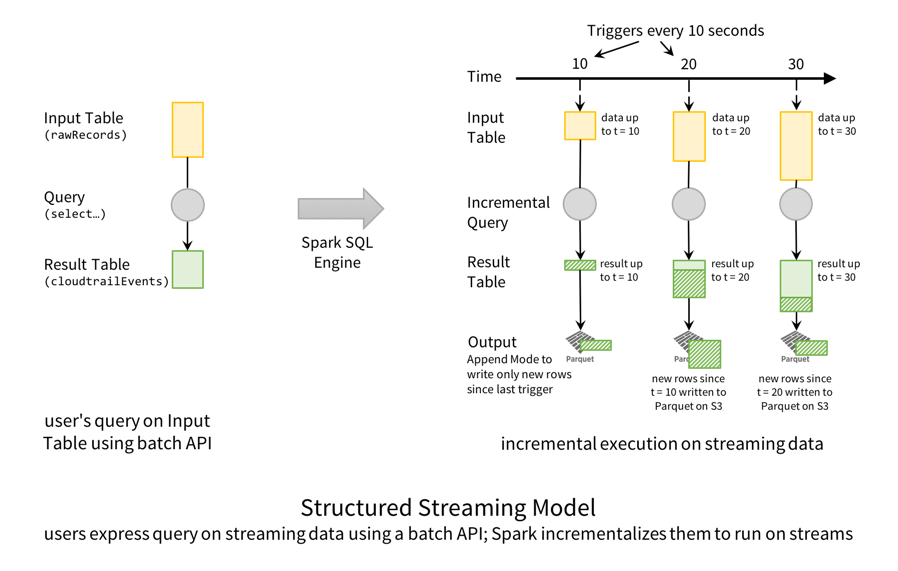

Conceptually, the rawRecords DataFrame is an append-only Input Table, and the cloudtrailEvents DataFrame is the transformed Result Table. In other words, when new rows are appended to the input (rawRecords), the result table (cloudtrailEvents) will have new transformed rows. In this particular case, every 10 seconds, Spark SQL engine triggers a check for new files. When it finds new data (i.e., new rows in the Input Table), it transforms the data to generate new rows in the Result Table, which then get written out as Parquet files.

Furthermore, while this streaming query is running, you can use Spark SQL to simultaneously query the Parquet table. The streaming query writes the Parquet data transactionally such that concurrent interactive query processing will always see a consistent view of the latest data. This strong guarantee is known as prefix-integrity and it makes Structured Streaming pipelines integrate nicely with the larger Continuous Application.

###Solving Production Challenges
Earlier, we highlighted a number of challenges that must be solved for running a streaming ETL pipeline in production. Let’s see how Structured Streaming running on the Databricks platform solves them.

####Recovering from Failures to get Exactly-once Fault-tolerance Guarantees
Long running pipelines must be able to tolerate machine failures. With Structured Streaming, achieving fault-tolerance is as easy as specifying a checkpoint location for the query. In the earlier code snippet, we did so in the following line.


```
.option("checkpointLocation", "/cloudtrail.checkpoint/")
```
This checkpoint directory is per query, and while a query is active, Spark continuously writes metadata of the processed data to the checkpoint directory. Even if the entire cluster fails, the query can be restarted on a new cluster, using the same checkpoint directory, and consistently recover. More specifically, on the new cluster, Spark uses the metadata to start the new query where the failed one left off, thus ensuring end-to-end exactly-once guarantees and data consistency
<br><br>
Furthermore, this same mechanism allows you to upgrade your query between restarts, as long as the input sources and output schema remain the same. Since Spark 2.1, we encode the checkpoint data in JSON for future-proof compatibility. So you can restart your query even after updating your Spark version. In all cases, you will get the same fault-tolerance and consistency guarantees.
<br><br>
####Monitoring, Alerting and Upgrading
For a Continuous Application to run smoothly, it must be robust to individual machine or even whole cluster failures. In Databricks, we have developed tight integration with Structured Streaming that allows us continuously monitor your StreamingQueries for failures (and automatically restart them. All you have to do is create a new Job, and configure the Job retry policy. You can also configure the job to send emails to notify you of failures.


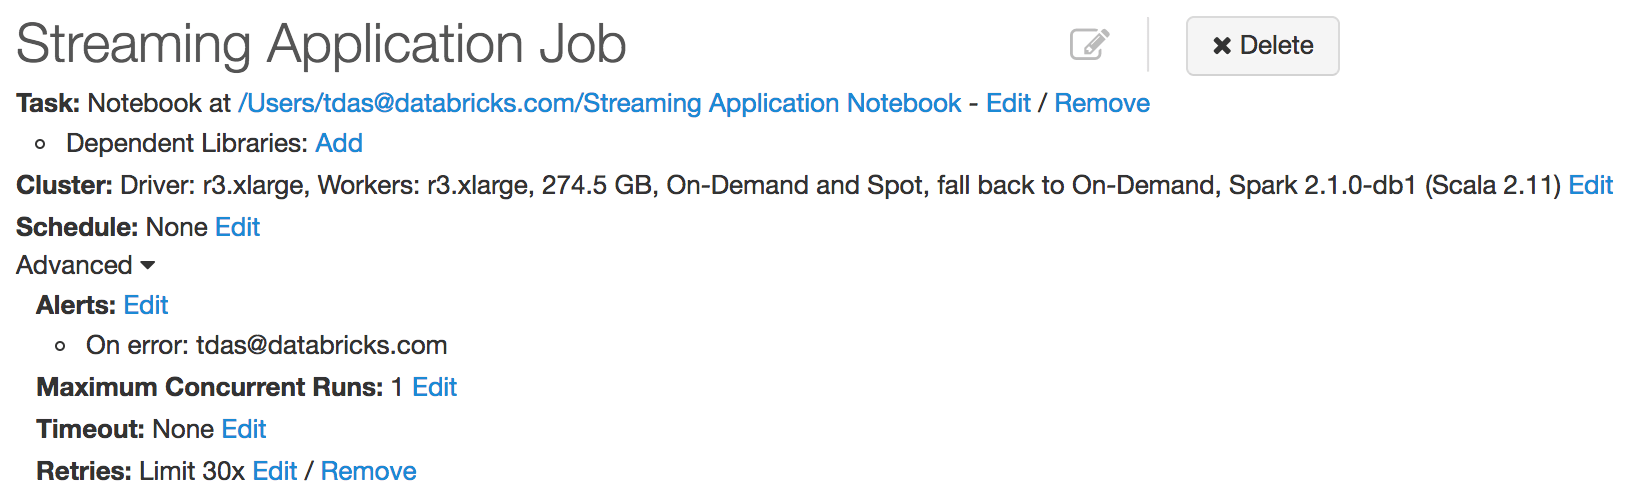

Machine failures are not the only situations that we need to handle to ensure robust processing. 
####Combining Live Data with Historical/Batch Data
Many applications require historical/batch data to be combined with live data. For example, besides the incoming audit logs, we may already have a large backlog of logs waiting to be converted. Ideally, we would like to achieve both, interactively query the latest data as soon as possible, and also have access to historical data for future analysis. It is often complex to set up such a pipeline using most existing systems as you would have to set up multiples processes: a batch job to convert the historical data, a streaming pipeline to convert the live data, and maybe a another step to combine the results.
<br><br>
Structured Streaming eliminates this challenge. You can configure the above query to prioritize the processing new data files as they arrive, while using the space cluster capacity to process the old files. First, we set the option latestFirst for the file source to true, so that new files are processed first. Then, we set the maxFilesPerTrigger to limit how many files to process every time. This tunes the query to update the downstream data warehouse more frequently, so that the latest data is made available for querying as soon as possible. Together, we can define the rawLogs DataFrame as follows:

In [ ]:
val rawJson = spark.readStream
  .schema(cloudTrailSchema)
  .option("latestFirst", "true")
  .option("maxFilesPerTrigger", "20")
  .json("s3n://mybucket/AWSLogs/*/CloudTrail/*/2017/01/*")

In this way, we can write a single query that easily combines live data with historical data, while ensuring low-latency, efficiency and data consistency.

# Data Exploration using PySpark

The describe function in pandas and spark will give us most of the statistical results, such as min, median, max, quartiles and standard deviation. With the help of the user defined function, you can get even more statistical results.

## Univariate Analysis

In mathematics, univariate refers to an expression, equation, function or polynomial of only one variable. “Uni” means “one”, so in other words your data has only one variable. So you do not need to deal with the causes or relationships in this step. Univariate analysis takes data, summarizes that variables (attributes) one by one and finds patterns in the data.

There are many ways that can describe patterns found in univariate data include central tendency (mean, mode and median) and dispersion: range, variance, maximum, minimum, quartiles (including the interquartile range), coefficient of variation and standard deviation. You also have several options for visualizing and describing data with univariate data. Such as frequency Distribution Tables, bar Charts, histograms, frequency Polygons, pie Charts.

The variable could be either categorical or numerical, we will demostrate the different statistical and visulization techniques to investigate each type of the variable.


## Numerical Variables

The describe function in pandas and spark will give us most of the statistical results, such as min, median, max, quartiles and standard deviation. With the help of the user defined function, you can get even more statistical results.


### Read and describe the file

In [ ]:
from pyspark.sql import SparkSession    
spark = SparkSession \
        .builder \
        .appName("Python Spark Data Exploration") \
        .config("spark.some.config.option", "some-value") \
        .getOrCreate()

In [ ]:
df = spark.read.format('com.databricks.spark.csv').\
                               options(header='true', \
                               inferschema='true').load("german_credit.csv",header=True);

In [ ]:
df.columns



```
['Creditability',
 'Account Balance',
 'Duration of Credit (month)',
 'Payment Status of Previous Credit',
 'Purpose',
 'Credit Amount',
 'Value Savings/Stocks',
 'Length of current employment',
 'Instalment per cent',
 'Sex & Marital Status',
 'Guarantors',
 'Duration in Current address',
 'Most valuable available asset',
 'Age (years)',
 'Concurrent Credits',
 'Type of apartment',
 'No of Credits at this Bank',
 'Occupation',
 'No of dependents',
 'Telephone',
 'Foreign Worker']
```



In [ ]:
df[['Account Balance','No of dependents']].toPandas().describe()

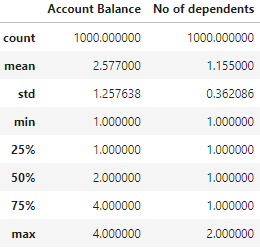

In [ ]:
# selected varables for the demonstration
num_cols = ['Account Balance','No of dependents']

In [ ]:
df.select(num_cols).describe().show()

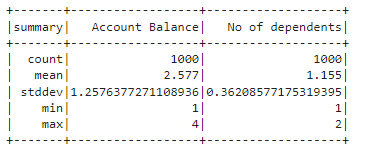

You may find out that the default function in PySpark does not include the quartiles. The following function will help you to get the same results in Pandas

In [ ]:
def describe_pd(df_in, columns, style):
    '''
    Function to union the basic stats results and deciles
    :param df_in: the input dataframe 
    :param columns: the cloumn name list of the numerical variable     
    :param style: the display style  

    :return : the numerical describe info. of the input dataframe   
    '''       

    if style == 1:
        percentiles = [25, 50, 75]
    else:
        percentiles = np.array(range(0, 110, 10))
    
    percs = np.transpose([np.percentile(df_in.select(x).collect(), percentiles) for x in columns])
    percs = pd.DataFrame(percs, columns=columns)
    percs['summary'] = [str(p) + '%' for p in percentiles]
    
    spark_describe = df_in.describe().toPandas()
    new_df = pd.concat([spark_describe, percs],ignore_index=True)
    new_df = new_df.round(2)
    return new_df[['summary'] + columns]

In [ ]:
output = describe_pd(df,num_cols,1)

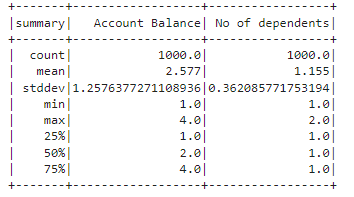

### Convert data type

In [ ]:
output['summary']= output['summary'].astype(str)
# convert just columns
output[num_cols] = output[num_cols].apply(pd.to_numeric)

In [ ]:
output.dtypes

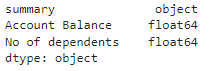

In [ ]:
output['summary']= output['summary'].astype(str)
# convert just columns
output[num_cols] = output[num_cols].apply(pd.to_numeric)
spark.createDataFrame(output).show()

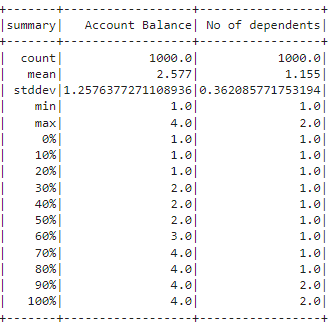

In [ ]:
df.select('Credit Amount').show(5)

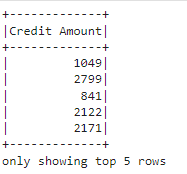

### Histrogram 

In [ ]:
data1 = df.select('Age (years)').toPandas()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

plt.rcParams['figure.figsize'] =(16,9)
plt.style.use('ggplot')
sns.set()

In [ ]:
var = 'Age (years)'
x = data1[var]
bins = np.arange(0, 100, 5.0)

plt.figure(figsize=(10,8))
# the histogram of the data
plt.hist(x, bins, alpha=0.8, histtype='bar', color='gold',
         ec='black',weights=np.zeros_like(x) + 100. / x.size)

plt.xlabel(var)
plt.ylabel('percentage')
plt.xticks(bins)
plt.show()

fig.savefig(var+".pdf", bbox_inches='tight')

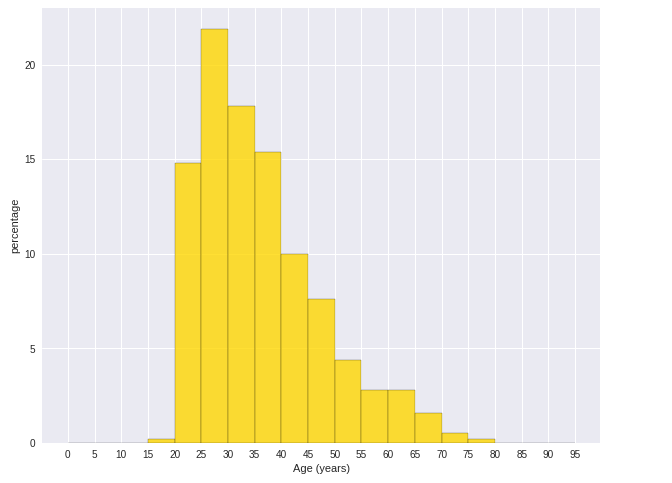

In [ ]:
var = 'Age (years)'
x = data1[var]
bins = np.arange(0, 100, 5.0)


########################################################################
hist, bin_edges = np.histogram(x,bins,
                               weights=np.zeros_like(x) + 100. / x.size) 
# make the histogram
 
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(1, 2, 1)

# Plot the histogram heights against integers on the x axis
ax.bar(range(len(hist)),hist,width=1,alpha=0.8,ec ='black', color='gold')
# # Set the ticks to the middle of the bars
ax.set_xticks([0.5+i for i,j in enumerate(hist)]) 
# Set the xticklabels to a string that tells us what the bin edges were
labels =['{}'.format(int(bins[i+1])) for i,j in enumerate(hist)]
labels.insert(0,'0')
ax.set_xticklabels(labels)
plt.xlabel(var)
plt.ylabel('percentage')

########################################################################

hist, bin_edges = np.histogram(x,bins) # make the histogram

ax = fig.add_subplot(1, 2, 2)
# Plot the histogram heights against integers on the x axis
ax.bar(range(len(hist)),hist,width=1,alpha=0.8,ec ='black', color='gold')
 
# # Set the ticks to the middle of the bars
ax.set_xticks([0.5+i for i,j in enumerate(hist)])
 
# Set the xticklabels to a string that tells us what the bin edges were
labels =['{}'.format(int(bins[i+1])) for i,j in enumerate(hist)]
labels.insert(0,'0')
ax.set_xticklabels(labels)
plt.xlabel(var)
plt.ylabel('count')
plt.suptitle('Histogram of {}: Left with percentage output;Right with count output'
             .format(var), size=16)
plt.show()

fig.savefig(var+".pdf", bbox_inches='tight')


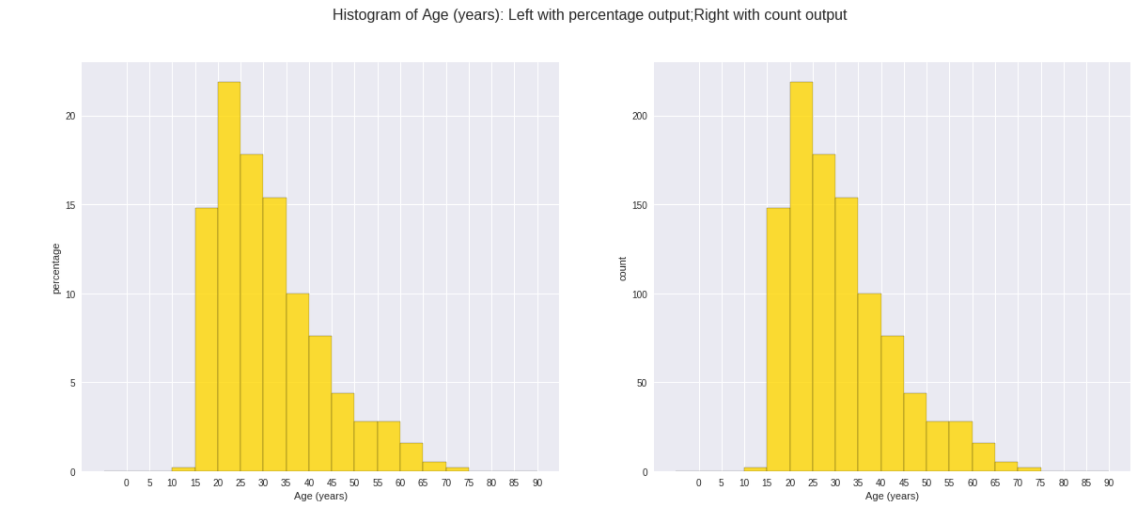

### Skewness and Kurtosis
In probability theory and statistics, skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean. The skewness value can be positive or negative, or undefined.For a unimodal distribution, negative skew commonly indicates that the tail is on the left side of the distribution, and positive skew indicates that the tail is on the right.


In [ ]:
from pyspark.sql.functions import col, skewness, kurtosis

In [ ]:
df.select(skewness(var),kurtosis(var)).show()

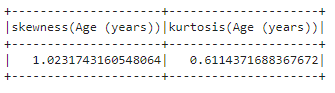

### Bucketing and binning

In [ ]:
def age_condition(x):
    if pd.isnull(x):
        return "missing"
    elif x <25:
        return "<25"
    elif 25 <= x <= 34:
        return "25-34"
    elif 35 <= x <= 44:
        return "35-44" 
    elif 45 <= x <= 54:
        return "45-54" 
    elif 55 <= x <= 64:
        return "55-64"     
    else:
        return "65+"

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, DoubleType

age_udf = udf(lambda x: age_condition(x), StringType())

In [ ]:
df = df.withColumn("age_class", age_udf("Age (years)"))

In [ ]:
df.select(['age_class','Age (years)']).show(3)

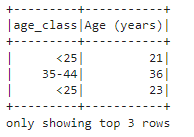

In [ ]:
df.select(['age_class','Credit Amount']).\
   groupBy('age_class').count().show()

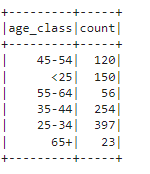

## Categorical Variables
Compared with the numerical variables, the categorical variables are much more easier to do the exploration.

### Frequency table

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.functions import rank,sum,col
from pyspark.sql import Window

window = Window.rowsBetween(Window.unboundedPreceding,Window.unboundedFollowing)
# withColumn('Percent %',F.format_string("%5.0f%%\n",col('Credit_num')*100/col('total'))).\
tab = df.select(['age_class','Credit Amount']).\
   groupBy('age_class').\
   agg(F.count('Credit Amount').alias('Credit_num'),
       F.mean('Credit Amount').alias('Credit_avg'),
       F.min('Credit Amount').alias('Credit_min'),
       F.max('Credit Amount').alias('Credit_max')).\
   withColumn('total',sum(col('Credit_num')).over(window)).\
   withColumn('Percent',col('Credit_num')*100/col('total')).\
   drop(col('total'))

In [ ]:
tab.show()

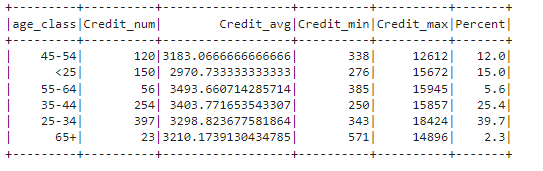

In [ ]:
plot_data = tab.toPandas() 
plot_data.sort_values('age_class')

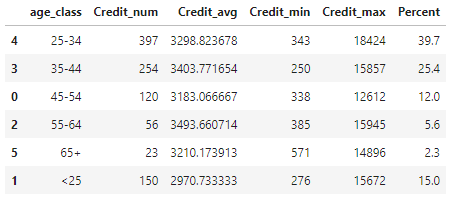

In [ ]:
custom_dict = {'<25': 0, '25-34': 1, '35-44': 2, '45-54': 3, '55-64': 4, '65+': 5}

In [ ]:
plot_data['index']= plot_data['age_class'].replace(custom_dict)

In [ ]:
plot_data.sort_values('index')

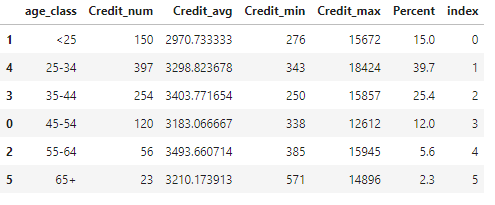

In [ ]:
plot_data = plot_data.sort_values('index')

 ### Pie plot

In [ ]:
# Data to plot
labels = plot_data.age_class
sizes =  plot_data.Percent
colors = ['gold', 'yellowgreen', 'lightcoral','blue', 'lightskyblue','green','red']
explode = (0, 0.1, 0, 0,0,0)  # explode 1st slice
 
# Plot
plt.figure(figsize=(10,8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

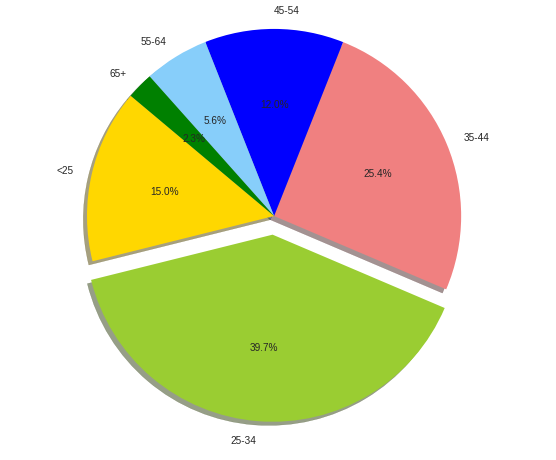

### Bar plot

In [ ]:
labels = plot_data.age_class
missing = plot_data.Percent
ind = [x for x, _ in enumerate(labels)]

plt.figure(figsize=(10,8))
plt.bar(ind, missing, width=0.8, label='missing', color='gold')

plt.xticks(ind, labels)
plt.ylabel("percentage")

plt.show()

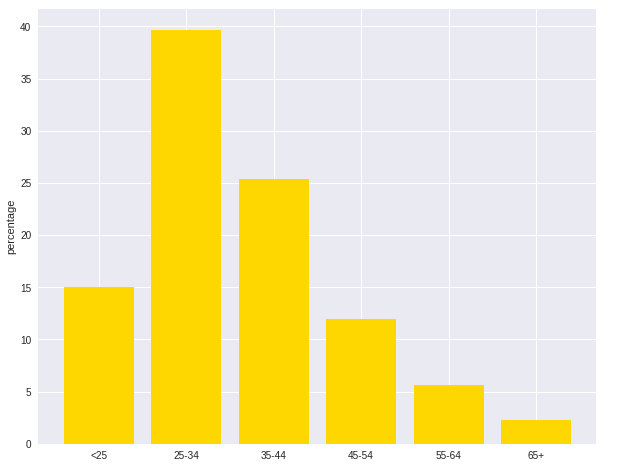

In [ ]:
labels = ['missing', '<25', '25-34', '35-44', '45-54','55-64','65+']
missing = np.array([0.000095, 0.024830, 0.028665, 0.029477, 0.031918,0.037073,0.026699])
man = np.array([0.000147, 0.036311, 0.038684, 0.044761, 0.051269, 0.059542, 0.054259])
women = np.array([0.004035, 0.032935, 0.035351, 0.041778, 0.048437, 0.056236,0.048091])
ind = [x for x, _ in enumerate(labels)]

plt.figure(figsize=(10,8))
plt.bar(ind, women, width=0.8, label='women', color='gold', bottom=man+missing)
plt.bar(ind, man, width=0.8, label='man', color='silver', bottom=missing)
plt.bar(ind, missing, width=0.8, label='missing', color='#CD853F')

plt.xticks(ind, labels)
plt.ylabel("percentage")
plt.legend(loc="upper left")
plt.title("demo")

plt.show()

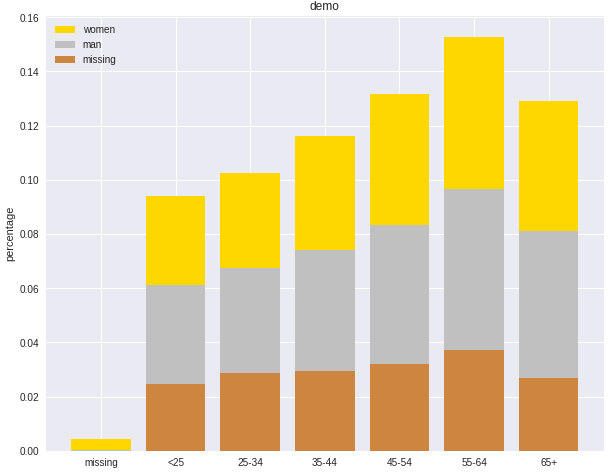

Sometimes, some people will ask you to plot the unequal width (invalid argument for histogram) of the bars. You can still achieve it by the following trick.

In [ ]:
# prepare for the plot data

var = 'Credit Amount'
plot_data = df.select(var).toPandas()
x= plot_data[var]

bins =[0,200,400,600,700,800,900,1000,2000,3000,4000,5000,6000,10000,25000] 

hist, bin_edges = np.histogram(x,bins,weights=np.zeros_like(x) + 100. / x.size) # make the histogram
 
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)
# Plot the histogram heights against integers on the x axis
ax.bar(range(len(hist)),hist,width=1,alpha=0.8,ec ='black',color = 'gold')
 
# # Set the ticks to the middle of the bars
ax.set_xticks([0.5+i for i,j in enumerate(hist)])
 
# Set the xticklabels to a string that tells us what the bin edges were
#labels =['{}k'.format(int(bins[i+1]/1000)) for i,j in enumerate(hist)]
labels =['{}'.format(bins[i+1]) for i,j in enumerate(hist)]
labels.insert(0,'0')
ax.set_xticklabels(labels)
#plt.text(-0.6, -1.4,'0')
plt.xlabel(var)
plt.ylabel('percentage')
plt.show()

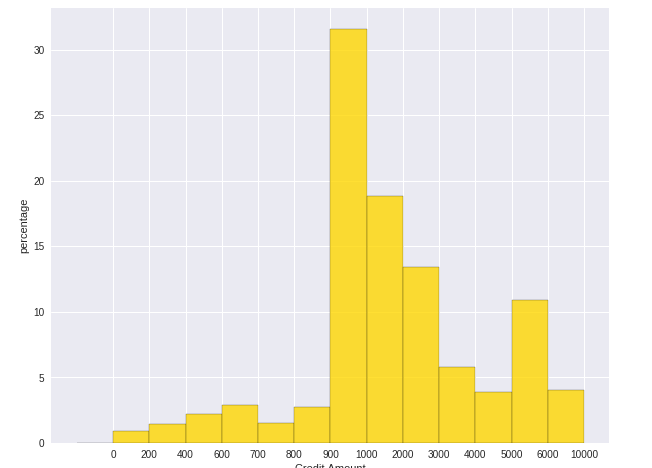

### Box plot and violin plot

Note that although violin plots are closely related to Tukey’s (1977) box plots, the violin plot can show more information than box plot. When we perform an exploratory analysis, nothing about the samples could be known. So the distribution of the samples can not be assumed to a normal distribution and usually when you get a big data, the normal distribution will show some out liars in box plot.



In [ ]:
x = df.select(var).toPandas()

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(1, 2, 1)
ax = sns.boxplot(data=x,color='gold')

ax = fig.add_subplot(1, 2, 2)
ax = sns.violinplot(data=x,color='gold')

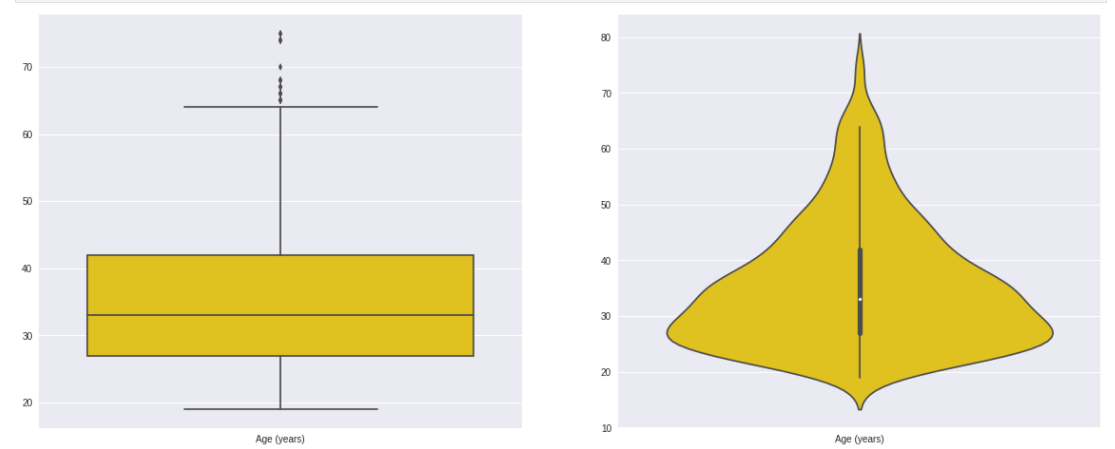

In [ ]:
corr_data = df.select(num_cols)

## Multivariate Analysis




### Correlation matrix

In [ ]:
from pyspark.mllib.stat import Statistics
import pandas as pd

corr_data = df.select(num_cols)

col_names = corr_data.columns
features = corr_data.rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names

print(corr_df.to_string())

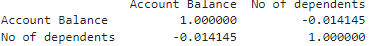

In [ ]:
spark.createDataFrame(corr_df).show()

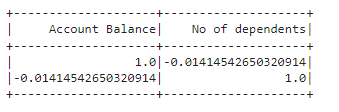

###  Scatter Plot


In [ ]:
import seaborn as sns
sns.set(style="ticks")

df = sns.load_dataset("iris")
sns.pairplot(df, hue="species")
plt.show()

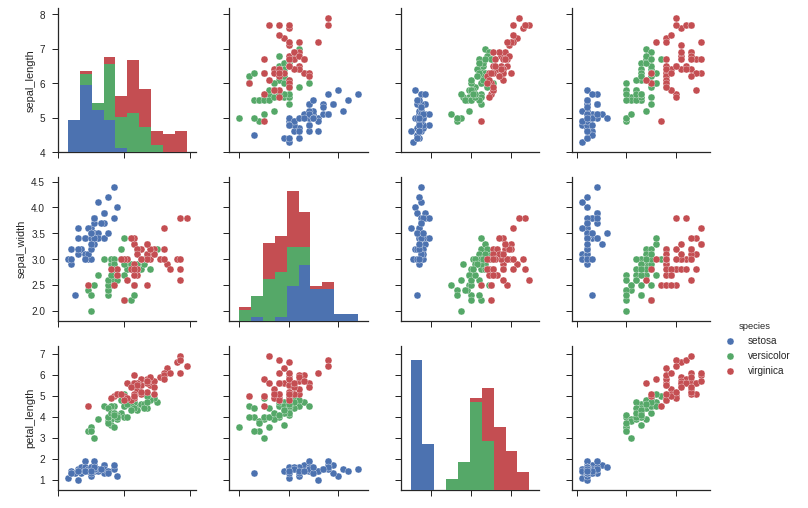
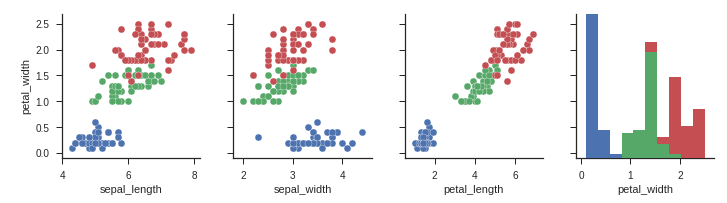

In [ ]:
print(corr_df.to_string())

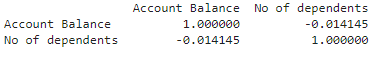

# Assesment 

Your manager has asked you to explore the use of pySpark to upgrade the existing ETL process for a potential clien. In order to understand the data and evaluate the quality of the data from the production grade point of view, which requires uniform and consistent data.

This time, you will need to perform exploration of the data using pySpark and point out the observation which can cause problem in the future.

This task requires that you prepare one deliverable:

Exploratory Data Analysis using pySpark, and a report on your observations on the quality issue (Zip File):

A Jupyter Notebook in which you:

* Perform Exploratory Data Analysis using pySpark.
  * Read the file 
  * Observe the data types 
  * Transform data types if needed
  * Numerical features distributions
  * Categorical features distributions
  
Explain how the results of each visualization you built and support for your conclusions.

The customer data is located in the GitHub repo.